In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

flight_data = pd.read_csv('/Users/komiyareiju/Desktop/flight_data(light).csv')
flight_data.head()

,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,OriginAirportID,OriginAirportSeqID,...,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,3,9,15,3,2021-09-15,DL,19790,DL,13487,1348702,...,165.0,141.0,1.0,1097.0,5,NaN,NaN,NaN,NaN,NaN
1,3,9,15,3,2021-09-15,DL,19790,DL,11042,1104205,...,109.0,82.0,1.0,554.0,3,NaN,NaN,NaN,NaN,NaN
2,3,9,15,3,2021-09-15,DL,19790,DL,12478,1247805,...,160.0,139.0,1.0,1089.0,5,NaN,NaN,NaN,NaN,NaN
3,3,9,15,3,2021-09-15,DL,19790,DL,10397,1039707,...,96.0,79.0,1.0,534.0,3,NaN,NaN,NaN,NaN,NaN
4,3,9,15,3,2021-09-15,DL,19790,DL,14869,1486903,...,94.0,79.0,1.0,546.0,3,NaN,NaN,NaN,NaN,NaN


## Note: Our overall objective is to predict if the flight delays or not (classification).

#### Tweak Some Variables for Predictors


We saw in the EDA that there were relatively more delays in Mon and Sun(using 'DayOfWeek'). 
We create a new boolean column 'BusyDay' to indicate these days as the busy days. 

In [2]:
# Create a new column 'Busy' based on the condition
flight_data['BusyDay'] = flight_data['DayOfWeek'].apply(lambda x: 1 if x in [1, 7] else 0)

# Display the updated DataFrame
print(flight_data.head())

   Quarter  Month  DayofMonth  DayOfWeek  FlightDate Operating_Airline   \
0        3      9          15          3  2021-09-15                 DL   
1        3      9          15          3  2021-09-15                 DL   
2        3      9          15          3  2021-09-15                 DL   
3        3      9          15          3  2021-09-15                 DL   
4        3      9          15          3  2021-09-15                 DL   

   DOT_ID_Operating_Airline IATA_Code_Operating_Airline  OriginAirportID  \
0                     19790                          DL            13487   
1                     19790                          DL            11042   
2                     19790                          DL            12478   
3                     19790                          DL            10397   
4                     19790                          DL            14869   

   OriginAirportSeqID  ...  AirTime Flights Distance DistanceGroup  \
0             1348702 

We also saw from EDA that there is a relation with the day of the time vs. median delay time.
We hypothesise that the hour for the flight also matters. We create a new column 'CRSDepTime_FirstTwoDigits' to show this. 

In [3]:
flight_data['CRSDepTime_FirstTwoDigits'] = flight_data['CRSDepTime'].astype(str).str[:2]

In [4]:
# Check variables so far
flight_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6185870 entries, 0 to 6185869
Data columns (total 55 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Quarter                      int64  
 1   Month                        int64  
 2   DayofMonth                   int64  
 3   DayOfWeek                    int64  
 4   FlightDate                   object 
 5   Operating_Airline            object 
 6   DOT_ID_Operating_Airline     int64  
 7   IATA_Code_Operating_Airline  object 
 8   OriginAirportID              int64  
 9   OriginAirportSeqID           int64  
 10  OriginCityMarketID           int64  
 11  Origin                       object 
 12  OriginCityName               object 
 13  OriginState                  object 
 14  OriginStateFips              int64  
 15  OriginStateName              object 
 16  OriginWac                    int64  
 17  DestAirportID                int64  
 18  DestAirportSeqID             int64  
 19  

We also saw there is huge variance within the flight delays. Thus, to predict accurately we remove outliers.

In [5]:
flight_data.dtypes

# Filter the DataFrame for flights with delay greater than 0 minute 
delayed_flights = flight_data[flight_data['DepDelayMinutes'] > 0]

# Get quartiles
quartiles_delayed = delayed_flights['DepDelayMinutes'].describe()[['25%', '50%', '75%']]

print("Quartiles of DepDelayMinutes for Delayed Flights (DepDelayMinutes > 0):")
print(quartiles_delayed)

Quartiles of DepDelayMinutes for Delayed Flights (DepDelayMinutes > 0):
25%     6.0
50%    16.0
75%    41.0
Name: DepDelayMinutes, dtype: float64


We see a huge jump from the 50% to the 75% quartile. We shall see in more increments to probe. 

In [6]:
delayed_flights = flight_data[flight_data['DepDelayMinutes'] > 0]

# Calculate more specific percentiles
percentiles = [75, 80, 85, 90, 95, 99]
quartiles_delayed = np.percentile(delayed_flights['DepDelayMinutes'], percentiles)

print("Quartiles of DepDelayMinutes for Delayed Flights (DepDelayMinutes > 0):")
for p, q in zip(percentiles, quartiles_delayed):
    print(f"{p}th percentile: {q}")

Quartiles of DepDelayMinutes for Delayed Flights (DepDelayMinutes > 0):
75th percentile: 41.0
80th percentile: 52.0
85th percentile: 68.0
90th percentile: 93.0
95th percentile: 143.0
99th percentile: 309.0


From the 85th percentile and onwards, there seems to be a large jump. We decide to consider this range as the range with outliers and thus proceed to remove it.

In [7]:
percentile_85 = np.percentile(flight_data['DepDelayMinutes'], 85)

# Drop rows where DepDelayMinutes is greater than 0 and at or above the 85th percentile
flight_data = flight_data.drop(flight_data[(flight_data['DepDelayMinutes'] > 0) & (flight_data['DepDelayMinutes'] >= percentile_85)].index)

In [8]:
# Check if the data has changed...(it has)

# Filter the DataFrame for flights with delay greater than 0 minute
delayed_flights = flight_data[flight_data['DepDelayMinutes'] > 0]

# Get quartiles
quartiles_delayed = delayed_flights['DepDelayMinutes'].describe()[['25%', '50%', '75%']]

print("Quartiles of DepDelayMinutes for Delayed Flights (DepDelayMinutes > 0):")
print(quartiles_delayed)

Quartiles of DepDelayMinutes for Delayed Flights (DepDelayMinutes > 0):
25%     3.0
50%     6.0
75%    11.0
Name: DepDelayMinutes, dtype: float64


We also check for missing values (NA) in each column. 

In [9]:
na_columns = flight_data.columns[flight_data.isna().any()]
na_counts = flight_data[na_columns].isna().sum()

# Display columns with missing values and their respective counts
print("Columns with missing values:")
print(na_counts)

Columns with missing values:
CarrierDelay         4978862
WeatherDelay         4978862
NASDelay             4978862
SecurityDelay        4978862
LateAircraftDelay    4978862
dtype: int64


We explore more.

In [10]:
# Select the columns
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Calculate quartiles for each delay column
quartiles = flight_data[delay_columns].describe(percentiles=[0.25, 0.5, 0.75])

# Print quartiles for each delay column
print("Quartiles of Delay Columns:")
print(quartiles)

Quartiles of Delay Columns:
        CarrierDelay   WeatherDelay       NASDelay  SecurityDelay  \
count  274423.000000  274423.000000  274423.000000  274423.000000   
mean        5.558404       0.470631      19.395575       0.053498   
std         9.850829       3.716319      17.622697       0.870569   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       7.000000       0.000000   
50%         0.000000       0.000000      17.000000       0.000000   
75%        10.000000       0.000000      26.000000       0.000000   
max       194.000000     184.000000     498.000000      63.000000   

       LateAircraftDelay  
count      274423.000000  
mean            1.571184  
std             4.809802  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max           149.000000  


We want to use the fillna method with mean. But we observe there is a lot of variance within the columns.
Thus we first remove the outliers for each column and then proceed to use the fillna method. 

In [11]:
# Create a copy of the original flight_data
flight_data_copy = flight_data.copy()

# Calculate quartiles for each delay column in the copy
quartiles = flight_data_copy[delay_columns].describe(percentiles=[0.25, 0.5, 0.75])

# Calculate IQR for each delay column
Q1 = quartiles.loc['25%']
Q3 = quartiles.loc['75%']
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers for each delay column from the copy
for column in delay_columns:
    flight_data_copy = flight_data_copy[(flight_data_copy[column] >= lower_bound[column]) & (flight_data_copy[column] <= upper_bound[column])]

# Calculate the mean for each delay column in the copy after removing outliers
mean_delay_columns = flight_data_copy[delay_columns].mean()

# Print the mean for each delay column
print("Mean of Delay Columns after removing outliers:")
for column in delay_columns:
    print(f"{column}: {mean_delay_columns[column]}")

Mean of Delay Columns after removing outliers:
CarrierDelay: 4.830258878372514
WeatherDelay: 0.0
NASDelay: 19.137928680446855
SecurityDelay: 0.0
LateAircraftDelay: 0.0


In [12]:
# Identify rows with NaN values in delay columns. Create new dataframe filled_df. 
filled_df = flight_data[flight_data[delay_columns].isna().any(axis=1)]

# Manually input the means for each column
filled_df['CarrierDelay'].fillna(4.830258878372514, inplace=True)
filled_df['NASDelay'].fillna(19.137928680446855, inplace=True)
filled_df['WeatherDelay'].fillna(0, inplace=True)
filled_df['SecurityDelay'].fillna(0, inplace=True)
filled_df['LateAircraftDelay'].fillna(0, inplace=True)

/var/folders/vr/jxcn32m10yb75616tykny2qr0000gn/T/ipykernel_65767/2779183331.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filled_df['CarrierDelay'].fillna(4.830258878372514, inplace=True)
/var/folders/vr/jxcn32m10yb75616tykny2qr0000gn/T/ipykernel_65767/2779183331.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filled_df['NASDelay'].fillna(19.137928680446855, inplace=True)
/var/folders/vr/jxcn32m10yb75616tykny2qr0000gn/T/ipykernel_65767/2779183331.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

### Modelling

On to the actual modelling. We saw during the EDA that the origin airport and the carrier were important predictors. Thus we pre-determine such factors already; else we will face too much of a variance within the delay times it is practically impossible to predict. Although we chose random variables here, you can choose any that you like as long as it is in the dataset. 

Also note that we use the 'filled_df' for the dataset and not flight data. This is because flight_data has the actual real-life 'delay_columns' (Weather Delay etc.), but fill_df only has the mean of it. You could think of it as essentially training the dataframe, or using accumulated variables in year X to predict delays in year X+1. In this way we avoid using response variables to predict response variables. 

We tried three different models: Decision Tree, Random Forest, and Logistic Regression.

In [13]:
# Pre-designate origin and airline randomly. 
# This airport and airline had a sufficient amount of data entries (around 50000) so we are fine to use it.
temp_data = filled_df.loc[(filled_df['Origin'] == 'ATL') & 
                            (filled_df['IATA_Code_Operating_Airline'] == '9E')]
# Drop necessary variables.
temp_data.drop(['DepDelay', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk',
                'ArrTime','ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',  
                'ArrTimeBlk', 'ActualElapsedTime', 'AirTime', 'Cancelled', 'DepTime'], axis=1, inplace=True)

/var/folders/vr/jxcn32m10yb75616tykny2qr0000gn/T/ipykernel_65767/3080390843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.drop(['DepDelay', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk',


In [14]:
# Predictors
temp_data.dtypes

Quarter                          int64
Month                            int64
DayofMonth                       int64
DayOfWeek                        int64
FlightDate                      object
Operating_Airline               object
DOT_ID_Operating_Airline         int64
IATA_Code_Operating_Airline     object
OriginAirportID                  int64
OriginAirportSeqID               int64
OriginCityMarketID               int64
Origin                          object
OriginCityName                  object
OriginState                     object
OriginStateFips                  int64
OriginStateName                 object
OriginWac                        int64
DestAirportID                    int64
DestAirportSeqID                 int64
DestCityMarketID                 int64
Dest                            object
DestCityName                    object
DestState                       object
DestStateFips                    int64
DestStateName                   object
DestWac                  

## Decision Tree

Decision Trees recursively partition the feature space based on our dataset’s features. Each internal node of the tree represents a decision based on a feature value, such as whether the departure time is before or after a certain threshold. These decisions lead to binary splits, creating a hierarchical structure that ultimately predicts the likelihood of a flight delay at the leaf nodes.

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier  
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score 

# Step 1: Create a binary target variable
temp_data['DepDelayAbove0'] = (temp_data['DepDelayMinutes'] > 0).astype(int)

# Step 2: Split the data into features (X) and binary target variable (y)
X = temp_data.drop(['DepDelayMinutes', 'DepDelayAbove0'], axis=1)
y = temp_data['DepDelayAbove0']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Preprocess numerical and categorical features separately
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Step 5: Create a pipeline with preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))  # Changed
])

# Step 6: Train the model
pipeline.fit(X_train, y_train)

# Step 7: Evaluate the trained model
y_pred = pipeline.predict(X_test)

# Evaluation metrics for classification
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/var/folders/vr/jxcn32m10yb75616tykny2qr0000gn/T/ipykernel_65767/2247738402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['DepDelayAbove0'] = (temp_data['DepDelayMinutes'] > 0).astype(int)


Accuracy: 0.8704184704184704


Let us print the confusion matrix.

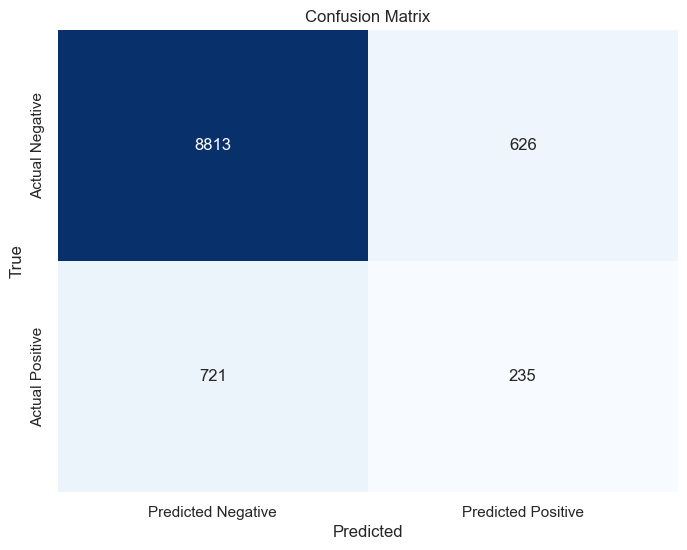

True Positive Rate (TPR): 0.25
True Negative Rate (TNR): 0.93
False Positive Rate (FPR): 0.07
False Negative Rate (FNR): 0.75


In [16]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate rates
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print rates
print("True Positive Rate (TPR): {:.2f}".format(tpr))
print("True Negative Rate (TNR): {:.2f}".format(tnr))
print("False Positive Rate (FPR): {:.2f}".format(fpr))
print("False Negative Rate (FNR): {:.2f}".format(fnr))


We see TPR and TNR rate is vastly different. This may be problematic as the test data we use might have been skewed. We then try changing the testing data to include a more larger group of data points. Concretely, instead of using 'filled_df', we use the original data set (while dropping some variables).

Accuracy: 0.8628131744393357


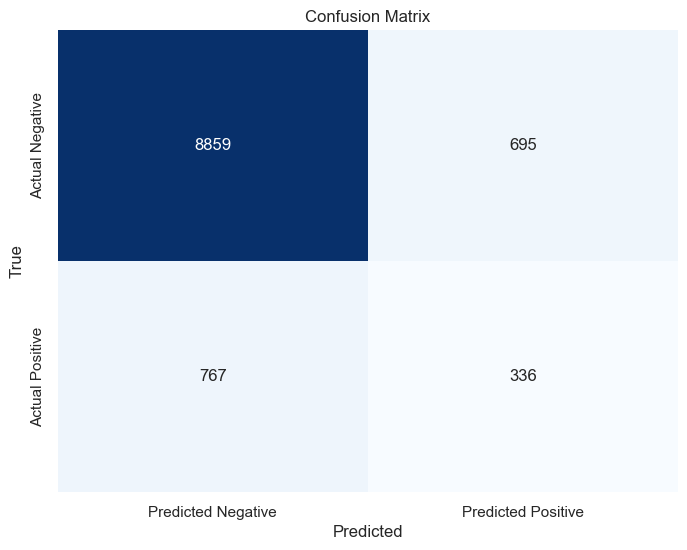

True Positive Rate (TPR): 0.30
True Negative Rate (TNR): 0.93
False Positive Rate (FPR): 0.07
False Negative Rate (FNR): 0.70


In [17]:
new_temp_data = flight_data.loc[(flight_data['Origin'] == 'ATL') & 
                                (flight_data['IATA_Code_Operating_Airline'] == '9E')]


# Drop columns without inplace=True or assign the result back to new_temp_data
new_temp_data = new_temp_data.drop(['DepDelay', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk',
                'ArrTime','ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',  
                'ArrTimeBlk', 'ActualElapsedTime', 'AirTime', 'Cancelled', 'DepTime', 'CarrierDelay', 'WeatherDelay',
                'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)

# Create a binary target variable
new_temp_data['DepDelayAbove0'] = (new_temp_data['DepDelayMinutes'] > 0).astype(int)

# Split the data into features (X) and binary target variable (y)
X = new_temp_data.drop(['DepDelayMinutes', 'DepDelayAbove0'], axis=1)
y = new_temp_data['DepDelayAbove0']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess numerical and categorical features separately
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline with preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))  
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the trained model
y_pred = pipeline.predict(X_test)

# Evaluation metrics for classification
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate rates
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print rates
print("True Positive Rate (TPR): {:.2f}".format(tpr))
print("True Negative Rate (TNR): {:.2f}".format(tnr))
print("False Positive Rate (FPR): {:.2f}".format(fpr))
print("False Negative Rate (FNR): {:.2f}".format(fnr))

We do not see much of a difference compared to when we used 'filled_df'. Thus, we observe that the high accuraccy comes from the fact that much more of the data contains non-delays than delays. It is hard to tweak variables and increase the TPR since this is just how the original dataset was like. However, we could increase the weightage for the minority class (i.e. the delayed flights) within the model, so that the TPR could increase.

/var/folders/vr/jxcn32m10yb75616tykny2qr0000gn/T/ipykernel_65767/756554680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['DepDelayAbove0'] = (temp_data['DepDelayMinutes'] > 0).astype(int)


Accuracy: 0.8575276575276576


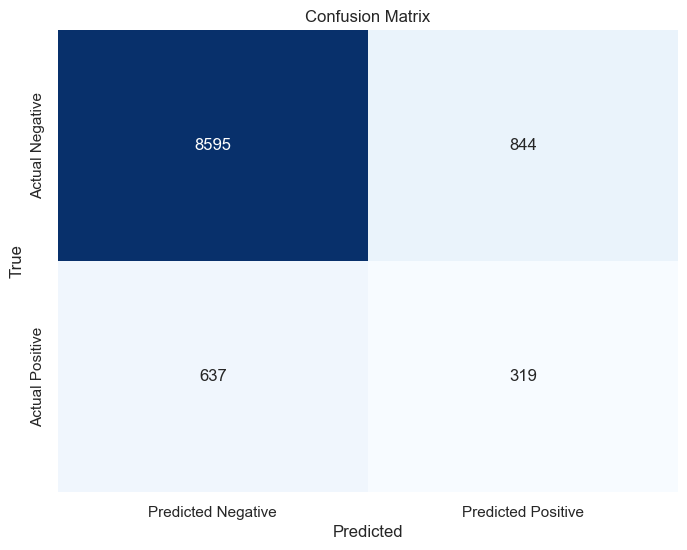

True Positive Rate (TPR): 0.33
True Negative Rate (TNR): 0.91
False Positive Rate (FPR): 0.09
False Negative Rate (FNR): 0.67


In [18]:
# Step 1: Create a binary target variable
temp_data['DepDelayAbove0'] = (temp_data['DepDelayMinutes'] > 0).astype(int)

# Step 2: Split the data into features (X) and binary target variable (y)
X = temp_data.drop(['DepDelayMinutes', 'DepDelayAbove0'], axis=1)
y = temp_data['DepDelayAbove0']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Preprocess numerical and categorical features separately
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 5: Create a pipeline with preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight={0: 1, 1: 100}, random_state=42))  
    # Here, the weight for the minority class (1) is set to 100.
])

# Step 6: Train the model
pipeline.fit(X_train, y_train)

# Step 7: Evaluate the trained model
y_pred = pipeline.predict(X_test)

# Evaluation metrics for classification
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate rates
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print rates
print("True Positive Rate (TPR): {:.2f}".format(tpr))
print("True Negative Rate (TNR): {:.2f}".format(tnr))
print("False Positive Rate (FPR): {:.2f}".format(fpr))
print("False Negative Rate (FNR): {:.2f}".format(fnr))


We observe a small increase in TPR.

## Random Forest 

Random Forest constructs multiple decision trees during training (classification) and aggregates their predictions through voting or averaging (regression). This allows it to capture the nonlinear interactions between various factors influencing flight delays. It also provides insight into feature importance by measuring the decrease in node impurity/information gain resulting from each feature's inclusion in the decision trees. This enables us to identify the most influential factors contributing to flight delays. 


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score  

# Step 1: Create a binary target variable
temp_data['DepDelayAbove0'] = (temp_data['DepDelayMinutes'] > 0).astype(int)

# Step 2: Split the data into features (X) and binary target variable (y)
X = temp_data.drop(['DepDelayMinutes', 'DepDelayAbove0'], axis=1)
y = temp_data['DepDelayAbove0']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Preprocess numerical and categorical features separately
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 5: Create a pipeline with preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  
])

# Step 6: Train the model
pipeline.fit(X_train, y_train)

# Step 7: Evaluate the trained model
y_pred = pipeline.predict(X_test)

# Evaluation metrics for classification
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/var/folders/vr/jxcn32m10yb75616tykny2qr0000gn/T/ipykernel_65767/281145642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['DepDelayAbove0'] = (temp_data['DepDelayMinutes'] > 0).astype(int)


Accuracy: 0.9098605098605098


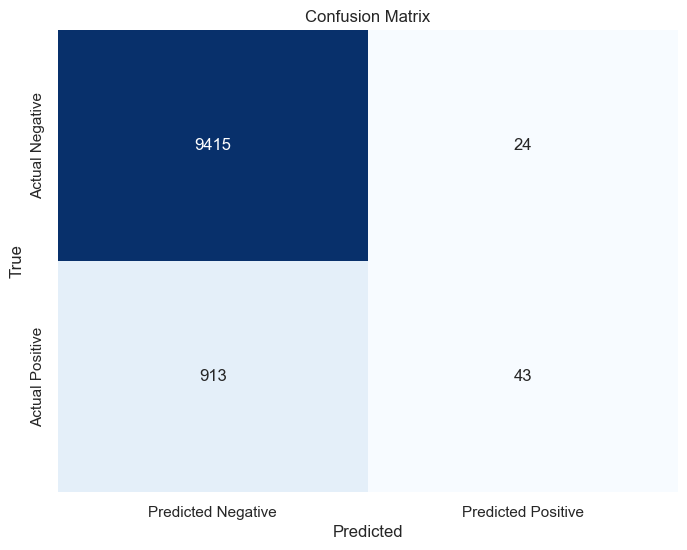

True Positive Rate (TPR): 0.04
True Negative Rate (TNR): 1.00
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.96


In [20]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate rates
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print rates
print("True Positive Rate (TPR): {:.2f}".format(tpr))
print("True Negative Rate (TNR): {:.2f}".format(tnr))
print("False Positive Rate (FPR): {:.2f}".format(fpr))
print("False Negative Rate (FNR): {:.2f}".format(fnr))

We tweaked the weight for this model but it did not improve so we skip it here.

## Logistic Regression

Logistic Regression is a method used for binary classification tasks, where the goal is to predict the probability of an instance belonging to one of two classes. It models the relationship between the independent variables (features) and the probability of a specific outcome using the logistic function, which produces output values between 0 and 1, making it suitable for estimating probabilities.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Define the list of categorical columns
categorical_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Operating_Airline ', 'DOT_ID_Operating_Airline', 
                       'IATA_Code_Operating_Airline','OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 
                       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 
                       'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 
                       'DestStateName', 'DestWac','BusyDay', 'CRSDepTime_FirstTwoDigits']

# Copy the original dataframe to avoid modifying the original data
temp_data_encoded = temp_data.copy()

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    temp_data_encoded[col] = label_encoder.fit_transform(temp_data_encoded[col])
    
# Convert DepDelayMinutes into a binary classification
temp_data_encoded['DepDelayMinutes_Class'] = (temp_data_encoded['DepDelayMinutes'] > 1).astype(int)  # Adjust threshold

# Split the data into train and test sets
X = temp_data_encoded.drop(['DepDelayMinutes', 'DepDelayMinutes_Class'], axis=1)  # Features
y = temp_data_encoded['DepDelayMinutes_Class']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9172679172679172


/Users/komiyareiju/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


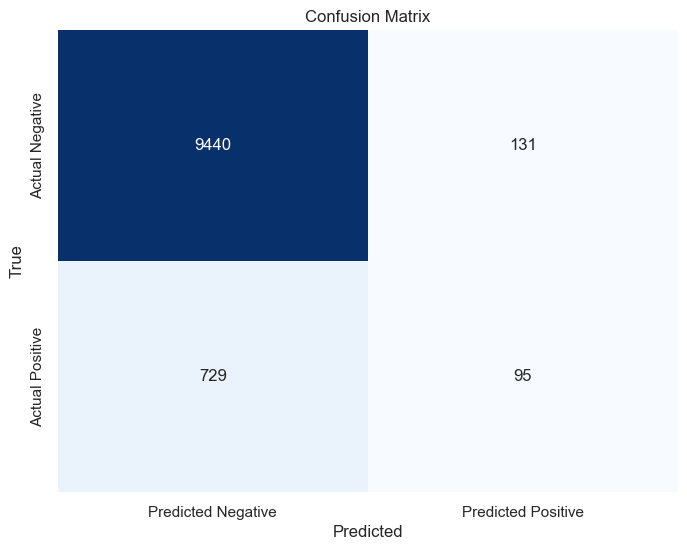

True Positive Rate (TPR): 0.12
True Negative Rate (TNR): 0.99
False Positive Rate (FPR): 0.01
False Negative Rate (FNR): 0.88


In [22]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate rates
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print rates
print("True Positive Rate (TPR): {:.2f}".format(tpr))
print("True Negative Rate (TNR): {:.2f}".format(tnr))
print("False Positive Rate (FPR): {:.2f}".format(fpr))
print("False Negative Rate (FNR): {:.2f}".format(fnr))

We tweak the weight.

Accuracy: 0.836940836940837


/Users/komiyareiju/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


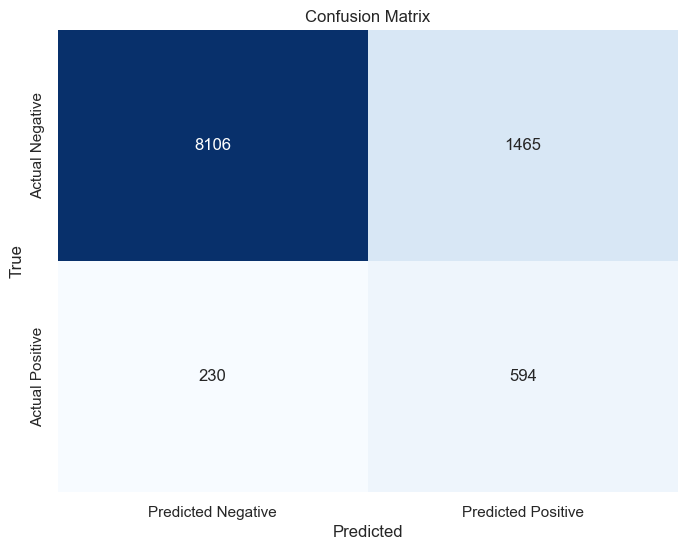

True Positive Rate (TPR): 0.72
True Negative Rate (TNR): 0.85
False Positive Rate (FPR): 0.15
False Negative Rate (FNR): 0.28


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Define the list of categorical columns
categorical_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Operating_Airline ', 'DOT_ID_Operating_Airline', 
                       'IATA_Code_Operating_Airline','OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 
                       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 
                       'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 
                       'DestStateName', 'DestWac','BusyDay', 'CRSDepTime_FirstTwoDigits']

# Copy the original dataframe to avoid modifying the original data
temp_data_encoded = temp_data.copy()

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    temp_data_encoded[col] = label_encoder.fit_transform(temp_data_encoded[col])
    
# Convert DepDelayMinutes into a binary classification
temp_data_encoded['DepDelayMinutes_Class'] = (temp_data_encoded['DepDelayMinutes'] > 1).astype(int)  # Adjust threshold

# Split the data into train and test sets
X = temp_data_encoded.drop(['DepDelayMinutes', 'DepDelayMinutes_Class'], axis=1)  # Features
y = temp_data_encoded['DepDelayMinutes_Class']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Logistic Regression model with class weights
class_weights = {0: 1, 1: 8}  # Adjust the weights as needed
log_reg = LogisticRegression(class_weight=class_weights)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate rates
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print rates
print("True Positive Rate (TPR): {:.2f}".format(tpr))
print("True Negative Rate (TNR): {:.2f}".format(tnr))
print("False Positive Rate (FPR): {:.2f}".format(fpr))
print("False Negative Rate (FNR): {:.2f}".format(fnr))

Good model! TPR is significantly higher than before. Let us increment the weight and see how TPR changes.

Accuracy: 0.7213083213083213


/Users/komiyareiju/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


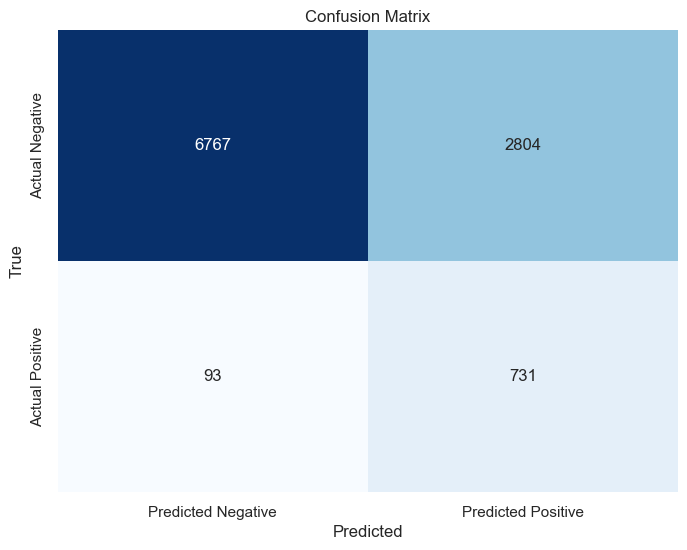

True Positive Rate (TPR): 0.89
True Negative Rate (TNR): 0.71
False Positive Rate (FPR): 0.29
False Negative Rate (FNR): 0.11


In [24]:
# Define the Logistic Regression model with class weights
class_weights = {0: 1, 1: 20}  # Adjust the weights as needed
log_reg = LogisticRegression(class_weight=class_weights)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate rates
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print rates
print("True Positive Rate (TPR): {:.2f}".format(tpr))
print("True Negative Rate (TNR): {:.2f}".format(tnr))
print("False Positive Rate (FPR): {:.2f}".format(fpr))
print("False Negative Rate (FNR): {:.2f}".format(fnr))

The accuracy for this model drops quite a lot from initially. However, considering the context, **it is more important to prioritize TPR rather than TNR; it is worse to be said that our flight is on time when it is NOT.** 

Blindly considering the overall accuracy, the ranking goes as follows: Logistic Regression > Random Forest > Decision Tree. Logistic Regression performs the best. 

Considering the TPR (which seems more appropriate to see in predicting flight delays), the ranking goes as: Logistic Regression (with weight) > Decision Tree > Random Forest. The most ideal model is Logistic Regression in this sense. 

## Conclusion

Compared to other notebooks on the internet, our model's accuracy may not be as good. However, the models we saw people often use with high accuracy included a major problem within them. It is that they include actual departure delay variables (such as DepDel15 or actual variables of WeatherDelay, SecurityDelay and so on, not even seperating the df) to predict DepDelayMinutes. It is hard to justify this as an optimal model. 

Another insight is that flight delays are not deterministic, and our high accuracy could have come by overfitting. Nonetheless, by using data like type of airline and (origin) airport, it makes sense if it predicts well; a specific route may have a higher possibility of delay than others. 

Overall, our model seems to balance out overfitting and accuracy, while also considering its real life applications.